In [43]:
import numpy as np
import pandas as pd

In [44]:
df = pd.read_csv('/Users/anhnguyendo/Documents/Python machine learning/Cali housing price project/California-house-pricing-prediction/data/processed/california_house_median_price_engineered.csv')
df.head()

,median_income,housing_age,avg_occupants,latitude,longitude,median_house_value,avg_rooms_bedrooms
0,8.3252,41.0,2.555556,37.88,-122.23,4.526,8.007937
1,8.3014,21.0,2.109842,37.86,-122.22,3.585,7.210018
2,7.2574,52.0,2.802260,37.85,-122.24,3.521,9.361582
3,5.6431,52.0,2.547945,37.85,-122.25,3.413,6.890411
4,3.8462,52.0,2.181467,37.85,-122.25,3.422,7.362934


In [45]:
#Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, f1_score, mean_absolute_error
from sklearn.pipeline import Pipeline

In [62]:
df_clean = df.dropna().copy()

y = df_clean['median_house_value']
X = df_clean.drop(columns='median_house_value')

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)        

lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)  # y_train is 1D, which is fine

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_pred = lr_model.predict(X_test_scaled)

print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))


RMSE: 0.7398560295952804
MAE: 0.5423287208461043
R²: 0.5822777822666418


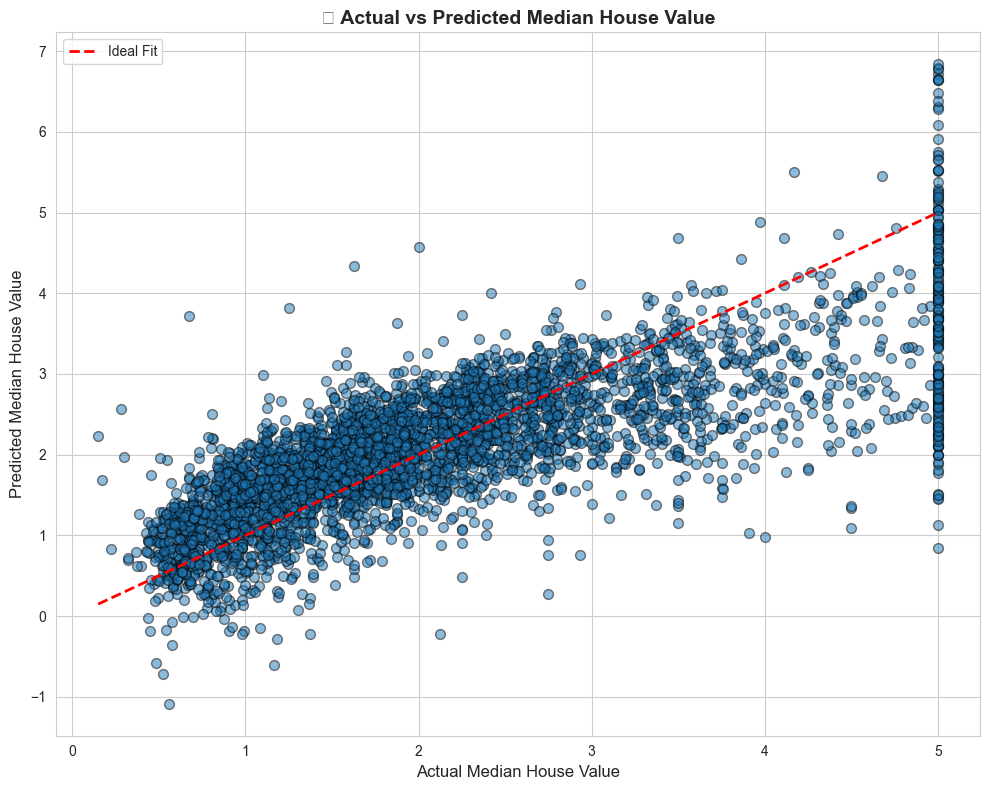

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred, alpha=0.5, edgecolor='k', s=50)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--',  lw=2, label='Ideal Fit')

plt.title("📈 Actual vs Predicted Median House Value", fontsize=14, weight='bold')
plt.xlabel("Actual Median House Value", fontsize=12)
plt.ylabel("Predicted Median House Value", fontsize=12)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend()
plt.tight_layout()

plt.savefig('/Users/anhnguyendo/Documents/Python machine learning/Cali housing price project/California-house-pricing-prediction/figures/Actual_vs_Predicted_House_Value_Linear_Regressin_model.png')
plt.show()


Model Performance Metrics
Root Mean Squared Error (RMSE): 0.74
- On average, your predictions deviate from actual values by 0.74 (in units of $100,000).
Mean Absolute Error (MAE): 0.54
- Half a million dollars off per house — reasonable for a simple linear model.
R² Score: 0.582
Linear Regerssion model explains 58.2% of the variation in home prices - not very ideal.

Model Visualization
Predictions cluster well along the ideal fit line in the mid-value range (1.5–3.5).
Model shows bias at the extreme high end:
- Predicted values underestimate actual values near the 5.0 ceiling and this is likely due to capping in the dataset (median_house_value capped at $500,000).

In [71]:
#try to address capping problem in the linear regression model
y_log = np.log1p(df_clean['median_house_value'])

X_train, X_test, y_log_train, y_log_test = train_test_split(X, y_log, test_size = 0.2, random_state = 42)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model_log = lr_model.fit(X_train_scaled, y_log_train)
y_log_pred = model_log.predict(X_test_scaled)

print("RMSE:", np.sqrt(mean_squared_error(y_log_test, y_log_pred)))
print("MAE:", mean_absolute_error(y_log_test, y_log_pred))
print("R²:", r2_score(y_log_test, y_log_pred))

RMSE: 0.22291875156853774
MAE: 0.16983189622503367
R²: 0.6057517977200613


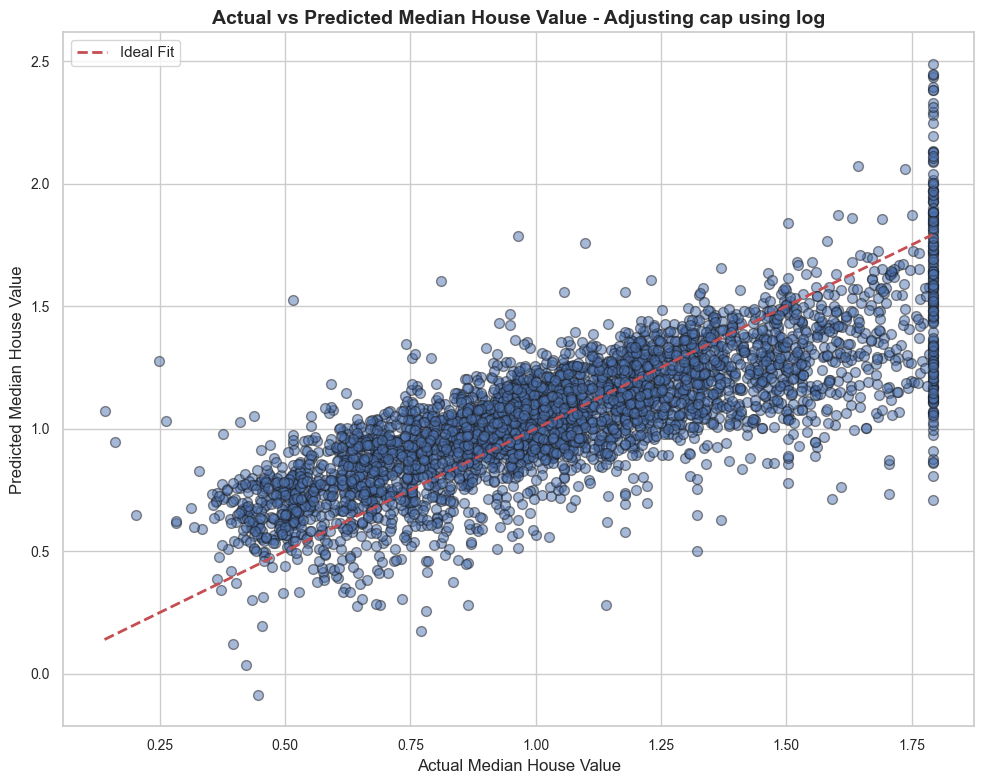

In [96]:
sns.set_style('whitegrid')

plt.figure(figsize=(10, 8))
plt.scatter(y_log_test, y_log_pred, alpha=0.5, edgecolor='k', s=50)
plt.plot([y_log_test.min(), y_log_test.max()], [y_log_test.min(), y_log_test.max()], 'r--',  lw=2, label='Ideal Fit')

plt.title("Actual vs Predicted Median House Value - Adjusting cap using log", fontsize=14, weight='bold')
plt.xlabel("Actual Median House Value", fontsize=12)
plt.ylabel("Predicted Median House Value", fontsize=12)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend()
plt.tight_layout()

plt.savefig('/Users/anhnguyendo/Documents/Python machine learning/Cali housing price project/California-house-pricing-prediction/figures/Actual_vs_Predicted_House_Value_Linear_Regressin_model_adjusting_capping_with_log.png')
plt.show()

When we look at the graph that generate using the Linear Regression Model but reducing the capping problem using log, we can clearly see that the result are closer with the ideal fit line. On the other hand, the log transformation flatten the cluster towards the end of the graph. 

In [81]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import normalize

tr = DecisionTreeRegressor()

X_norm = normalize(X, axis =1, norm = 'l1', copy=False)

X_tr_train, X_tr_test, y_tr_train, y_tr_test = train_test_split(X_norm, y, test_size = 0.2, random_state = 42)

param_grid_tr = {'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

model_tr = GridSearchCV(estimator = tr, param_grid = param_grid_tr, cv = 3, scoring = 'neg_mean_squared_error')

model_tr.fit(X_tr_train, y_tr_train)

GridSearchCV(cv=3, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [None, 5, 10],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='neg_mean_squared_error')

In [86]:
best_tr = model_tr.best_estimator_

y_tr_pred = best_tr.predict(X_tr_test)

rmse_tr = np.sqrt(mean_squared_error(y_tr_test, y_tr_pred))
mae_tr = mean_absolute_error(y_tr_test, y_tr_pred)
r2_tr = r2_score(y_tr_test, y_tr_pred)

print("Best Params:", model_tr.best_params_)
print("GridSearch Decision Tree Results:")
print(f"RMSE: {rmse_tr:.2f}")
print(f"MAE: {mae_tr:.2f}")
print(f"R²: {r2_tr:.4f}")

Best Params: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}
GridSearch Decision Tree Results:
RMSE: 0.74
MAE: 0.54
R²: 0.5835


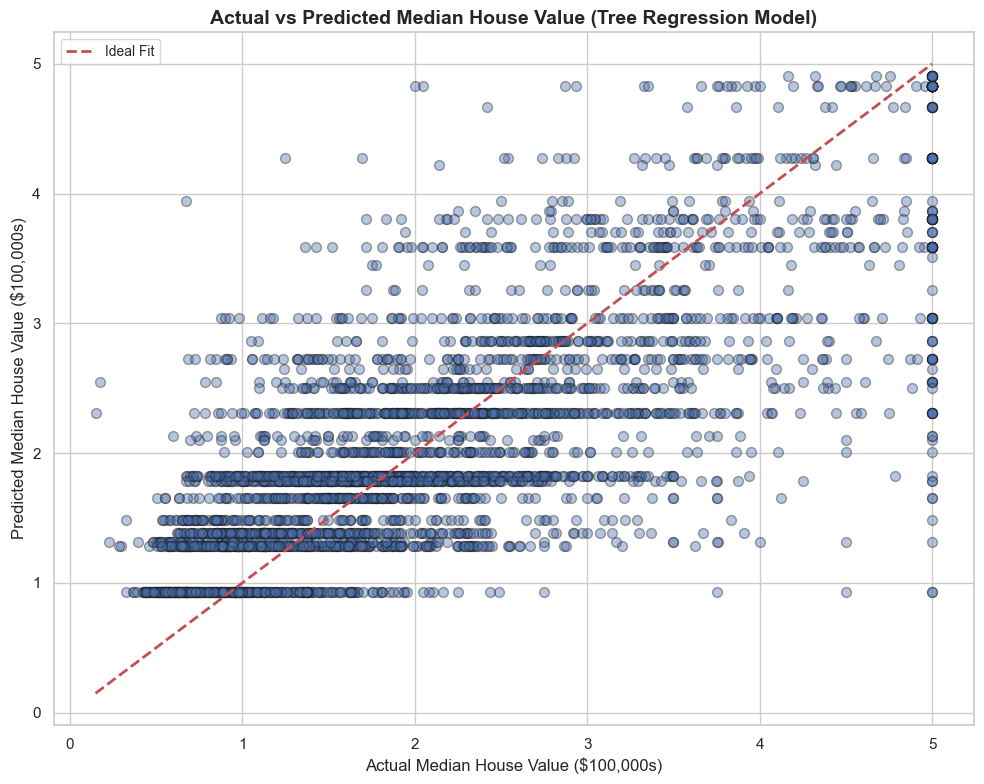

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns

# Seaborn style
sns.set(style="whitegrid")

# Plot
plt.figure(figsize=(10, 8))
plt.scatter(y_tr_test, y_tr_pred, alpha=0.4, edgecolor='k', s=50)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Ideal Fit')

plt.title("Actual vs Predicted Median House Value (Tree Regression Model)", fontsize=14, weight='bold')
plt.xlabel("Actual Median House Value ($100,000s)", fontsize=12)
plt.ylabel("Predicted Median House Value ($100,000s)", fontsize=12)
plt.legend(fontsize=10)
plt.tight_layout()

plt.savefig('/Users/anhnguyendo/Documents/Python machine learning/Cali housing price project/California-house-pricing-prediction/figures/Actual_vs_Predicted_House_Value_using_Tree_Regression_model.png')
plt.show()

The performance is almost identical to your baseline Linear Regression (RMSE ~0.74, R² ~0.58). The visualization ndicates the Decision Tree is too simple to capture the complex structure in the data. the model likely suffers from underfitting, as evidenced by the low max depth (5).

Overall, the predictions are flattened across wide price ranges (classic tree behavior). They model have fewer unique predicted values = each leaf assigns one constant value. Model fails to capture continuous variation in home prices, especially at the high end.

In [75]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()

param_grid = {'n_estimators': [100,150,200],
              'max_depth': [10,20, None],
              'min_samples_leaf' : [1,2],
              'min_samples_split' : [2,5]}

model_rf = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, scoring = 'neg_root_mean_squared_error',
                       n_jobs = -1, verbose = 1)

model_rf.fit(X_train, y_log_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [10, 20, None],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 150, 200]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [84]:
#best_model
best_rf_model = model_rf.best_estimator_ 

y_pred_log = best_rf_model.predict(X_test)
y_pred = np.expm1(y_pred_log) #inverse tranform using exponential transform 
y_test = np.expm1(y_log_test)

# Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred))
mae_rf = mean_absolute_error(y_test, y_pred)
r2_rf = r2_score(y_test, y_pred)

print("Best Params:", model_rf.best_params_)
print("GridSearch Random Forest Results:")
print(f"RMSE: {rmse_rf:.2f}")
print(f"MAE: {mae_rf:.2f}")
print(f"R²: {r2_rf:.4f}")

Best Params: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
GridSearch Random Forest Results:
RMSE: 0.51
MAE: 0.31
R²: 0.8035


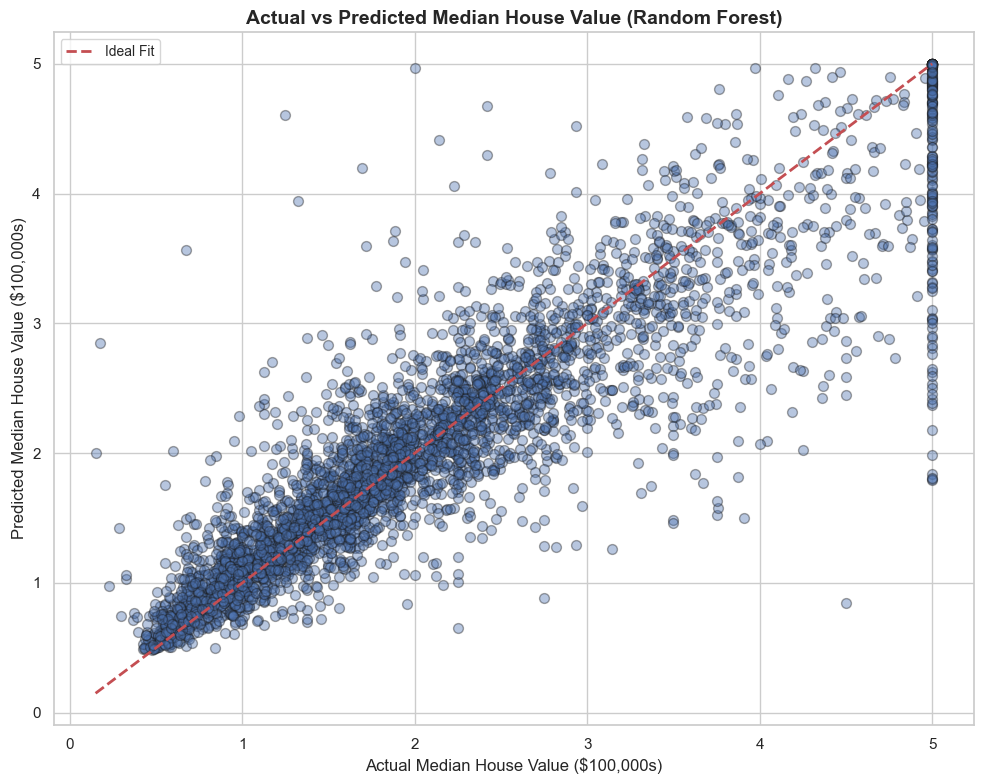

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns

# Seaborn style
sns.set(style="whitegrid")

# Plot
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred, alpha=0.4, edgecolor='k', s=50)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Ideal Fit')

plt.title("Actual vs Predicted Median House Value (Random Forest)", fontsize=14, weight='bold')
plt.xlabel("Actual Median House Value ($100,000s)", fontsize=12)
plt.ylabel("Predicted Median House Value ($100,000s)", fontsize=12)
plt.legend(fontsize=10)
plt.tight_layout()

plt.savefig('/Users/anhnguyendo/Documents/Python machine learning/Cali housing price project/California-house-pricing-prediction/figures/Actual_vs_Predicted_House_Value_using_Random_Forest_model.png')
plt.show()


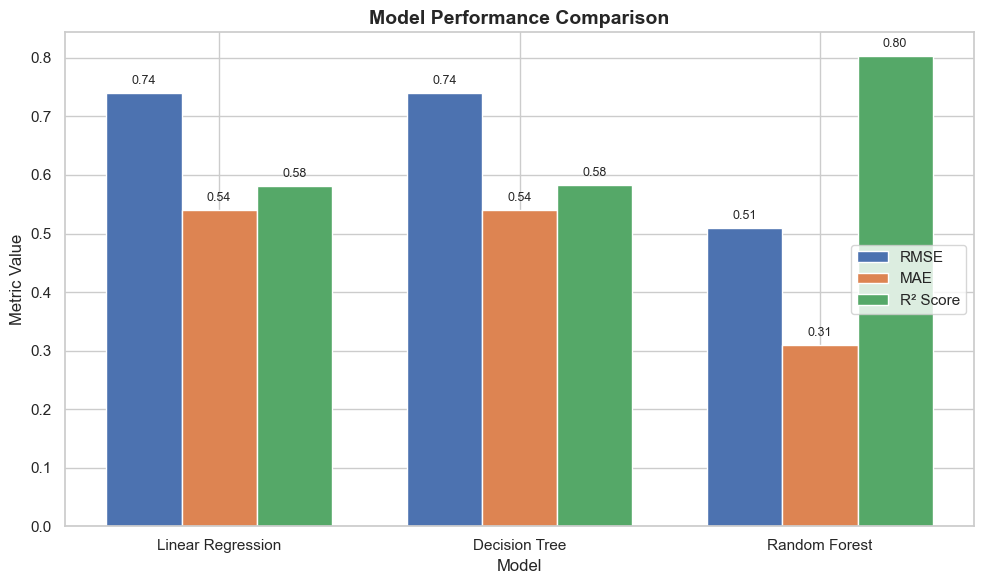

In [93]:
# Define model names and their metrics
models = ['Linear Regression', 'Decision Tree', 'Random Forest']
rmse_scores = [0.74, 0.74, 0.51]
mae_scores = [0.54, 0.54, 0.31]
r2_scores  = [0.582, 0.5835, 0.8035]

x = np.arange(len(models))
width = 0.25

fig, ax1 = plt.subplots(figsize=(10, 6))

bars1 = ax1.bar(x - width, rmse_scores, width, label='RMSE')
bars2 = ax1.bar(x, mae_scores, width, label='MAE')
bars3 = ax1.bar(x + width, r2_scores, width, label='R² Score')

# Labels and titles
ax1.set_xlabel('Model', fontsize=12)
ax1.set_ylabel('Metric Value', fontsize=12)
ax1.set_title('Model Performance Comparison', fontsize=14, weight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(models, fontsize=11)
ax1.legend()

def annotate_bars(bars):
    for bar in bars:
        yval = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f"{yval:.2f}", ha='center', va='bottom', fontsize=9)

annotate_bars(bars1)
annotate_bars(bars2)
annotate_bars(bars3)

plt.tight_layout()
plt.show()


Interpretation of the Bar Graph

RMSE (Root Mean Squared Error) – Lower is better
- Random Forest: 0.51 ✅
- Linear Regression: 0.74
- Decision Tree: 0.74
Random Forest has the lowest RMSE, meaning its predictions are, on average, closer to the true values.

MAE (Mean Absolute Error) – Lower is better
- Random Forest: 0.31 ✅
- Linear Regression: 0.54
- Decision Tree: 0.54
The Random Forest again performs best, with average errors of only $31,000 (assuming units are $100,000s).

R² Score (Coefficient of Determination) – Higher is better
- Random Forest: 0.80 ✅
- Linear Regression: 0.58
- Decision Tree: 0.58
Random Forest explains 80% of the variance in housing prices — far more than the other two models.

Best Model: Random Forest Regressor
- Best overall performance	RMSE, MAE, and R² are all significantly better than the others.
- Captures non-linear relationships	Works well with complex features like income, location, and population.
- Robust to outliers and feature interactions	No need for extensive preprocessing or assumptions.